# Tarea 1: Entendimiento de los datos con PySpark

## Enunciado
Ahora que ya aprendió a usar PySpark para exploración y preprocesamiento de datos, lo invitamos a que realice el proceso de entendimiento de datos de la tabla movimientosCopia, que registra el movimiento en inventario de un producto.
En esta actividad le recomendamos revisar el diccionario de datos suministrado y en particular la información relacionada con esta tabla. Si tienen alguna duda relacionada a esta tabla deben incluirla en las preguntas o aclaraciones que le entreguen al negocio. En relación a los datos Wide World Importers menciona:
- La cantidad máxima de productos movidos es 50 millones por viaje
- Existen 236.668 movimientos de producto realizados desde 2013
- Los movimientos están relacionados con 228.265 clientes
- El formato de fechas manejado es YYYY-MM-DD HH:MM:SS
- Actualmente tenemos 13 proveedores
Idealmente debe terminar con una lista de preguntas o aclaraciones para la organización, conclusiones de los datos/problemas de calidad y alternativas para la limpieza.
Recuerde en particular revisar la infografía de entendimiento de datos.



Continuando con el proyecto de consultoria de Wide World Importers, el primer paso para iniciar la comprensión de los datos es explorar y entender las fuentes de datos disponibles. Note que esto también nos ayuda a comprender mejor la organización.

## Configuración e importe de paquetes
Se utilizará el paquete de pandas profiling para apoyar el análisis estadístico, y se importan los paquetes de python
necesarios

In [12]:
from pyspark.sql import SparkSession
from pyspark.sql import functions
from pyspark.sql.types import StructType
from pyspark import SparkContext, SparkConf, SQLContext
from pyspark.sql.types import FloatType, StringType, IntegerType, DateType
from pyspark.sql.functions import udf, col, length, isnan, when, count, trim
import pyspark.sql.functions as f
import os 
from datetime import datetime
from pyspark.sql import types as t
from pandas_profiling import ProfileReport
#import matplotlib.pyplot as plt
import numpy as np

Configuración del controlador e inicio de sesion Spark

In [2]:
path_jar_driver = 'C:\Program Files (x86)\MySQL\Connector J 8.0\mysql-connector-java-8.0.28.jar'

In [3]:
#Configuración de la sesión
conf=SparkConf() \
    .set('spark.driver.extraClassPath', path_jar_driver)

spark_context = SparkContext(conf=conf)
sql_context = SQLContext(spark_context)
spark = sql_context.sparkSession

C:\Users\estudiante\anaconda3\envs\Tutoriales\lib\site-packages\pyspark\sql\context.py:79: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  FutureWarning


In [4]:
# Si quiere practicar la conexion con el servidor de base de datos:
db_connection_string = 'jdbc:mysql://157.253.236.116:8080/WWImportersTransactional'
# El usuario es su estudiante _i asignado y su contraseña la encontrará en el archivo excel de Coursera 
db_user = 'Estudiante_37'
db_psswd = 'QV8UJT16LT'

PATH='./'

In [5]:
def obtener_dataframe_de_bd(db_connection_string, sql, db_user, db_psswd):
    df_bd = spark.read.format('jdbc')\
        .option('url', db_connection_string) \
        .option('dbtable', sql) \
        .option('user', db_user) \
        .option('password', db_psswd) \
        .option('driver', 'com.mysql.cj.jdbc.Driver') \
        .load()
    return df_bd

## Sumario
A partir de los resultados de actividades previas, debes hacer el entendimiento de los datos de una fuente de datos. El detalle lo encuentras en la tarea del entendimiento de los datos: ENLACE TAREA.  Utiliza  como guía la infografía compartida del tema de entendimiento de datos.

## Criterios de revisión
Los criterios generales para la evaluación de la actividad son:

## Completitud del perfilamiento de datos (40 puntos)

In [69]:
sql_movimientos_copia = 'WWImportersTransactional.movimientosCopia'
sql_proveedores_copia = 'WWImportersTransactional.provedoresCopia'
sql_tipos_transaccion = '''(SELECT mov.TransaccionProductoID, mov.TipoTransaccionID, tt.TipoTransaccionNombre
FROM WWImportersTransactional.movimientosCopia as mov inner join WWImportersTransactional.TiposTransaccion as tt
on mov.TipoTransaccionID = tt.TipoTransaccionID) as Compatible'''
sql_clientes = 'WWImportersTransactional.Clientes'

In [70]:
#Se cargan los dataframes desde la base de datos
movimientos = obtener_dataframe_de_bd(db_connection_string, sql_movimientos_copia, db_user, db_psswd)
proveedores = obtener_dataframe_de_bd(db_connection_string, sql_proveedores_copia, db_user, db_psswd)
tipos_transaccion = obtener_dataframe_de_bd(db_connection_string, sql_tipos_transaccion, db_user, db_psswd)
clientes = obtener_dataframe_de_bd(db_connection_string, sql_clientes, db_user, db_psswd)

#### 1.1. Cantidad de registros y cantidad de columnas por tipo de dato

In [31]:
proveedores.show(5)

+-----------+--------------------+--------------------+--------------------------+------------------------+---------------+---------------+--------+-------------------+--------------------+--------------------+-----------------+----------------+------------------------+--------+--------------------+--------------+--------------+--------------------+----------+--------------------+------------+--------------------+----------------+----------------+-------------+----------------+
|ProveedorID|     NombreProveedor|CategoriaProveedorID|PersonaContactoPrincipalID|PersonaContactoAlternoID|MetodoEntregaID|CiudadEntregaID|CiudadID|ReferenciaProveedor|   NombreCuentaBanco|    MarcaCuentaBanco|CodigoCuentaBanco|NumeroCuentaBaco|CodigoInternacionalBanco|DiasPago| ComentariosInternos|NumeroTelefono|     NumeroFax|                 URL|Direccion1|          Direccion2|CodigoPostal|    UbicacionEntrega|DireccionPostal1|DireccionPostal2|CodigoPostal2|UltimaEdicionPor|
+-----------+--------------------+

In [27]:
# estructura de tabla movimientos, colunnas por tipo de dato
print(movimientos.schema)

StructType(List(StructField(TransaccionProductoID,IntegerType,true),StructField(ProductoID,IntegerType,true),StructField(TipoTransaccionID,IntegerType,true),StructField(ClienteID,DoubleType,true),StructField(InvoiceID,DoubleType,true),StructField(ProveedorID,StringType,true),StructField(OrdenDeCompraID,StringType,true),StructField(FechaTransaccion,StringType,true),StructField(Cantidad,DoubleType,true)))


En la tabla movimientos tenemos información de los movimientos de productos, se puede observar que se cuenta con información de la transacción, el ID de la orden de compra e invoice así como la cantidad de productos por cada movimiento. Parece que aquí se registran varios tipos de transacción, probablemente entradas y salidas entre otros tipos de transacciones/movimientos. Una primera aclaración a solicitar por parte del negocio es los tipos de transacción.

In [28]:
# estructura de tabla proveedores, colunnas por tipo de dato
print(proveedores.schema)

StructType(List(StructField(ProveedorID,IntegerType,true),StructField(NombreProveedor,StringType,true),StructField(CategoriaProveedorID,IntegerType,true),StructField(PersonaContactoPrincipalID,IntegerType,true),StructField(PersonaContactoAlternoID,IntegerType,true),StructField(MetodoEntregaID,DoubleType,true),StructField(CiudadEntregaID,IntegerType,true),StructField(CiudadID,IntegerType,true),StructField(ReferenciaProveedor,StringType,true),StructField(NombreCuentaBanco,StringType,true),StructField(MarcaCuentaBanco,StringType,true),StructField(CodigoCuentaBanco,IntegerType,true),StructField(NumeroCuentaBaco,LongType,true),StructField(CodigoInternacionalBanco,IntegerType,true),StructField(DiasPago,IntegerType,true),StructField(ComentariosInternos,StringType,true),StructField(NumeroTelefono,StringType,true),StructField(NumeroFax,StringType,true),StructField(URL,StringType,true),StructField(Direccion1,StringType,true),StructField(Direccion2,StringType,true),StructField(CodigoPostal,Intege

En la tabla proveedores podemos observar que se cuenta con una información casi detallada del proveedor, se tienen atributos como nombre, categoría y contacto así como información de dirección y de billing. En total son 27 atributos.

In [25]:
# cantidad de registros y numero de columnas
print((movimientos.count(), len(movimientos.columns)), (proveedores.count(), len(proveedores.columns)))

(204292, 9) (19, 27)


En total tenemos 204.292 movimientos y 19 proveedores y tenemos en total 36 variables a revisar de las cuales 6 son nùmericas asociadas a las movimientos y 3 son cadenas de caracteres, por otro lado, 14 son numericas asociadas a los proveedores y las demás son cadenas de caracteres.

#### 1.2. Significado de una fila

In [ ]:
movimientos.show(5)
movimientos.groupby("ProveedorID").count().orderBy("count", ascending=False).show(5)
movimientos.filter(movimientos["ProveedorID"] == 4.0).show(5)
movimientos.filter(movimientos["ProveedorID"] == 4.0).show(5)

+---------------------+----------+-----------------+---------+---------+-----------+---------------+----------------+--------+
|TransaccionProductoID|ProductoID|TipoTransaccionID|ClienteID|InvoiceID|ProveedorID|OrdenDeCompraID|FechaTransaccion|Cantidad|
+---------------------+----------+-----------------+---------+---------+-----------+---------------+----------------+--------+
|               118903|       217|               10|    476.0|  24904.0|           |               |     Apr 25,2014|   -40.0|
|               286890|       135|               10|     33.0|  60117.0|           |               |     Dec 10,2015|    -7.0|
|               285233|       111|               10|    180.0|  59768.0|           |               |     Dec 04,2015|    -2.0|
|               290145|       213|               10|     33.0|  60795.0|           |               |     Dec 23,2015|    -3.0|
|               247492|        90|               10|     55.0|  51851.0|           |               |     Jul 27

Con estos análisis podemos concluir que una fila de movimientos representa un movimiento realizado por un cliente (salida) o una entrada (compra) realizada por la empresa. Mientras que los proveedores coincide con su ID y contiene información detallada del proveedor asociado a movimientos de entrada.

#### 1.3 Estadísticas descriptivas por columna (numérica, categórica, fechas) 


In [29]:
movimientos.summary().show()

+-------+---------------------+------------------+-------------------+------------------+-----------------+-----------------+------------------+--------------------+-----------------+
|summary|TransaccionProductoID|        ProductoID|  TipoTransaccionID|         ClienteID|        InvoiceID|      ProveedorID|   OrdenDeCompraID|    FechaTransaccion|         Cantidad|
+-------+---------------------+------------------+-------------------+------------------+-----------------+-----------------+------------------+--------------------+-----------------+
|  count|               204292|            204292|             204292|            204292|           204292|           204292|            204292|              204292|           204292|
|   mean|   212458.04047637695|110.70090850351458| 10.035253460732676| 517.3252941867523|42957.26929590978|4.951898734177215|1345.9973277074544|                null|719.4997650421946|
| stddev|    71352.37579752573| 63.49014746219581|0.18563716955046372|353.501369

En las estadísticas anteriores vemos que las columna FechaTransaccion tiene un valor minimo y maximo correctos, no obstante los de de percentil aon iguales a  null, esto podría significar un error o no en la regla # 4 por lo que se analizará esta variable y la regla asociada a este posteriormente, también, se observa que la cantidad de movimientos es 204292 y que han sido realizados desde el 2013 (la fecha minima) por lo que la regla # 2 no es del todo cierta, se debe informar al negocio para saber si faltan datos o hay un error, observo que la columna TipoTransaccionID no contiene nulos y parece ser que solo tiene valores entre 10 y 12 lo cual me hace pensar que todas las transacciones estan correctamente asociadas a un único tipo de trasancción y que la inferencia inicial de que registra transacciones de entrasa y salida parece ser correcta, se debe confirmar con el negocio. Con respecto a la columna ProveedorID se puede ver que los IDs van de null (una posible salida) a 7, hace pensar que posiblemente solo se esten comprando productos de ciertos proveedores por lo que la regla # 5 se debería confirmar con el negocio, se le notificará sobre este hallazgo.
El valor mínimo de cantidad es -360 (Salida de 360 unidades) y el máximo es de 67368, el valor máximo de Cantidad parece tener valores extremos, pues en su percentil 75% el valor máximo era -5, es decir, para el 75% de los datos, el valor de Cantidad no superaba el -5, no obstante, estos se valores se analizarán con un gráfico de cajas. Además podemos ver que inicialmente la regla # 1 parece estar cumpliendose pues no se ve ningún movimiento con una cantidad superior a 50 millones.
finalmente, también observamos el calculo de la media para las columnas ID, esto se hace automatico pues son columnas cuyo tipo de dato es numerico, sin embargo estas no son variables numericas por lo cual calcular y/o analizar la media no tiene sentido.

{'whiskers': [<matplotlib.lines.Line2D at 0x189fa473308>,
 'caps': [<matplotlib.lines.Line2D at 0x189f9185b88>,
 'boxes': [<matplotlib.lines.Line2D at 0x189fa478c08>],
 'medians': [<matplotlib.lines.Line2D at 0x189fe927c08>],
 'fliers': [<matplotlib.lines.Line2D at 0x189f9b724c8>],
 'means': []}

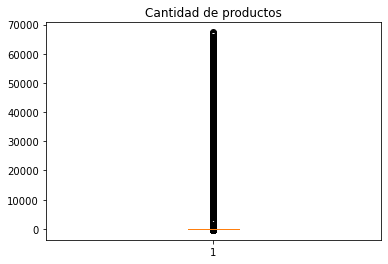

In [13]:
%matplotlib inline
import matplotlib.pyplot as plt

fig1, ax1 = plt.subplots()
ax1.set_title('Cantidad de productos')
ax1.boxplot(np.array(movimientos.select('Cantidad').collect()))


En el diagrama de cajas anterior podemos observar que la variable cantidad no tiene valores extremos, la asunción inicial queda descartada.

In [15]:
movimientos.groupby("ProveedorID").count().orderBy("count", ascending=False).show(5)

+-----------+------+
|ProveedorID| count|
+-----------+------+
|           |197182|
|        4.0|  4832|
|        7.0|  2267|
|        1.0|    11|
+-----------+------+



Con respecto a los proveedores podemos confirmar que de los 13 proveedores solo se registran movimientos asociados a 3 proveedores. Podría ser un error o no, se notificará al negocio.

In [27]:
movimientos.groupby("TipoTransaccionID").count().orderBy("count", ascending=False).show(5)
tipos_transaccion.groupby("TipoTransaccionNombre").count().orderBy("count", ascending=False).show(5)

+-----------------+------+
|TipoTransaccionID| count|
+-----------------+------+
|               10|197136|
|               11|  7110|
|               12|    46|
+-----------------+------+

+---------------------+------+
|TipoTransaccionNombre| count|
+---------------------+------+
|          Stock Issue|197136|
|        Stock Receipt|  7110|
| Stock Adjustment ...|    46|
+---------------------+------+



En relación a los tipos de transacción confirmamos que todas las transacciones están asociadas a un tipo y que actualmente tenemos movimientos de 3 tipos, y que el 96% de movimientos son de tipo Stock Issue, que entiendo es salida de stock.

In [29]:
movimientos.select(col('ClienteID')).distinct().count()

664

Con respecto a la regla de negocio # 3 se puede observar que no es correcta con los datos que tenemos actualmente, tenemos movimientos relacionados solo a 664 diferentes clientes no con 228265 clientes, se debe notificar al negocio para entender si falta datos o hay errores.

In [41]:
regex = "[0-2]\d{3}-(0[1-9]|1[0-2])-(0[1-9]|[1-2][0-9]|3[0-1])"
cumplenFormato = movimientos.filter(movimientos["FechaTransaccion"].rlike(regex))
noCumplenFormato = movimientos.filter(~movimientos["FechaTransaccion"].rlike(regex))
nullFecha = movimientos.filter(movimientos["FechaTransaccion"].isNull())
print("Número total de movimientos: "+str(movimientos.count())+", número de movimientos con formato correcto: "+str(cumplenFormato.count()))
noCumplenFormato.show()
nullFecha.show()

Número total de movimientos: 204292, número de movimientos con formato correcto: 140038
+---------------------+----------+-----------------+---------+---------+-----------+---------------+----------------+--------+
|TransaccionProductoID|ProductoID|TipoTransaccionID|ClienteID|InvoiceID|ProveedorID|OrdenDeCompraID|FechaTransaccion|Cantidad|
+---------------------+----------+-----------------+---------+---------+-----------+---------------+----------------+--------+
|               118903|       217|               10|    476.0|  24904.0|           |               |     Apr 25,2014|   -40.0|
|               286890|       135|               10|     33.0|  60117.0|           |               |     Dec 10,2015|    -7.0|
|               285233|       111|               10|    180.0|  59768.0|           |               |     Dec 04,2015|    -2.0|
|               290145|       213|               10|     33.0|  60795.0|           |               |     Dec 23,2015|    -3.0|
|               247492|

Podemos observar que no hay fechas nulas, por lo que la impresión inicial sobre fechas nulas no es correcta, quizá los percentiles aparecen nulos porque no se pueden calcular de manera regular, tendría que hacerse un código particular para analizar percentiles en campos de fecha, también tenemos 64254 movimientos que no cumplen con el formato especificado, solo parecer ser problema de formato así que se informará esto al negocio porque es algo que se puede corregir fácilmente.

In [76]:
reporte = ProfileReport(movimientos.toPandas())
reporte.to_file(PATH+"movimientos_reporte_prefilamiento.html")

Summarize dataset:  60%|██████    | 12/20 [00:03<00:01,  4.88it/s, Calculate kendall correlation]         C:\Users\estudiante\anaconda3\envs\Tutoriales\lib\site-packages\scipy\stats\stats.py:4812: RuntimeWarning: overflow encountered in longlong_scalars
  (2 * xtie * ytie) / m + x0 * y0 / (9 * m * (size - 2)))
Export report to file: 100%|██████████| 1/1 [00:00<00:00, 28.58it/s]


Seccion general del reporte:

Tenemos 9 variables y 204292 registros (es decir, movimientos), de las cuales 5 son numericas, 4 categoricas.
En los datos hay 29.3% de datos vacíos, (conclusión)

El archivo ocupa en memoria 11.7 MB

Hay un 15% de registros duplicados

Sección de variables del reporte:

Note que para cada variable nos dan estadisticos como la media, mínimo y máximo asi como un histograma de distribución de la variable, para nuestros datos no observamos nada por fuera de lo comun. (Como valores extremos)

OrdenDeCompraId y FechaTransaccion tienen alta cardinalidad, TransaccionProductoID, ProductoID, TipoTransaccionID, ClienteID, InvoiceID, ProveedorID y Cantidad son columnas que tienen una alta correlación.


Sección de interacciones y correlaciones:

Parecen haber columnas con correlaciones(Spearman) iguales a 1, esto significa que ambas columnas representan la misma información, no obstante, parecer ser una falsa alerta, ya que al ser columnas que almacenan IDs, hay posibilidad que hayan IDs númericos iguales no obstante representa información diferente, por ejemplo TransactionProductID puede tener valor 100 e InvoiceID también lo cual no significa necesariamente que haya un error de datos ya que son PKs de tablas diferentes y al ser númericas puede existir registros en ambas tablas con ID iguales como el mencionado.

## Completitud del análisis de la calidad de datos (40 puntos) 
- 2.1. Completitud: Datos que no existen o no se conocen
- 2.2. Unicidad: Datos que son idénticos en diferentes registros o registros con valores idénticos en atributos en los que no debería ocurrir
- 2.3. Consistencia: Esta medida se define por la validez o integridad del dato, en la definición de su estructura, al interior de una fila o entre diferentes filas de la misma fuente o de diferentes fuentes. El manejo de unidades en los datos y el significado del dato son generadores de inconsistencias.
- 2.4 Validez: Datos correctos en el contextoCompletitud del análisis de la calidad de datos


#### Unicidad y validez

Parte de la validez se revisó en el perfilamiento general, en la regla de negocio 2, 3 y 4 al final de la sección 1.3. Por otro lado, respecto a la unicidad a continuación haremos un analisis basado en si existen movimientos repetidos y/o idénticos.

In [45]:
print((movimientos.distinct().count(), movimientos.count()))
print(movimientos.select(col('TransaccionProductoID')).distinct().count())

(173659, 204292)
173659


De este analisis de unicidad se puede decir que tenemos 30663 movimentos completamente repetidos ya que adicionalmente se reviso los datos por la llave primaria de la tabla movimientos y la cantidad de registros únicos fue igual a la de los registros idénticos 173659. Tenemos un 15% de registros repetidos en la tabla movimientos, esto nos indica que probablemente haya un error en los datos, se debe notificar al negocio para entender mejor la situación.

In [49]:
movimientos.groupby("TransaccionProductoID").count().filter(col("count") > 1).show(5)

+---------------------+-----+
|TransaccionProductoID|count|
+---------------------+-----+
|               197953|    2|
|               101055|    2|
|               309597|    2|
|               209326|    2|
|               213516|    2|
+---------------------+-----+
only showing top 5 rows



In [54]:
# anakizando una de las PK repetidas 197953
movimientos.filter(col("TransaccionProductoID") == 197953).show()

+---------------------+----------+-----------------+---------+---------+-----------+---------------+--------------------+--------+
|TransaccionProductoID|ProductoID|TipoTransaccionID|ClienteID|InvoiceID|ProveedorID|OrdenDeCompraID|    FechaTransaccion|Cantidad|
+---------------------+----------+-----------------+---------+---------+-----------+---------------+--------------------+--------+
|               197953|       212|               10|    174.0|  41456.0|           |               |2015-02-12 12:00:...|   -10.0|
|               197953|       212|               10|    174.0|  41456.0|           |               |2015-02-12 12:00:...|   -10.0|
+---------------------+----------+-----------------+---------+---------+-----------+---------------+--------------------+--------+



Se puede comprobar que efectivamente los 30663 registros corresponde a movimientos repetidos en todas sus variables en la tabla movimientos

#### Completitud y validez

In [67]:
def contar_vacios(df):
    resultados = []
    for c in df.columns:
        vacios = df.filter(df[c].isNull()).count()
        if vacios!=0:
            print('número de vacíos para columna '+c+': '+str( vacios ))
            resultados.append(vacios)
        else:
            vacios = df.filter(trim(df[c])=="").count()
            if vacios!=0:
                print('número de vacíos para columna '+c+': '+str( vacios ))
                resultados.append(vacios)
    return resultados

def cardinalidad(df):
    resultado = {}
    for c in df.columns:
        cardinalidad = df.select(col(c)).distinct().count()
        if cardinalidad>=df.count()*0.5:
            resultado[c] = cardinalidad
    return resultado

In [68]:
print("Movimientos analisis de vacios ")
columnas_vacias_movimientos = contar_vacios(movimientos)
print("Movimientos analisis de cardinalidad ")
columnas_alta_cardinalidad_movimientos = cardinalidad(movimientos)
print(columnas_alta_cardinalidad_movimientos)

Movimientos analisis de vacios 
número de vacíos para columna ProveedorID: 197182
número de vacíos para columna OrdenDeCompraID: 197182
Movimientos analisis de cardinalidad 
{'TransaccionProductoID': 173659}


Como podemos observar para los movimientos las columnas ProveedorID tiene 197182 vacios, la columna OrdenDeCompraID tiene 197182. Parte de la completitud se analizo en la sección 1.
Respecto a cardinalidad, solo la columna TransaccionProductoID tiene una cardinalidad cercana al 85%.

### Consistencia
A nivel de consistencia podemos revisar los valores de la columna cantidad en relación con el tipo de transacción/movimiento. En nuestro caso vamos a verificar que todas las cantidades -sean negativas o positivas- en primer lugar sean diferente a cero y segundo que tengan relación con el tipo de transacción, por ejemplo un movimiento de entrada no debería tener una cantidad negativa sino una positiva y viceversa.

In [63]:
# Stock Issue = 10 (salida de stock)
# Stock Receipt = 11 (entrada de stock)
# Stock Adjustment = 12 (entrada o salida de stock)
numero_de_stock_issue_con_error = movimientos.filter(col("TipoTransaccionID") == 10).filter(col("Cantidad") >= 0).count()
print(f'Numero de movimientos tipo Stock Issue con error: {numero_de_stock_issue_con_error}')

numero_de_stock_receipt_con_error = movimientos.filter(col("TipoTransaccionID") == 11).filter(col("Cantidad") <= 0).count()
print(f'Numero de movimientos tipo Stock Receipt con error: {numero_de_stock_receipt_con_error}')

stock_adjustment = movimientos.filter(col("TipoTransaccionID") == 12).filter(col("Cantidad") == 0)
numero_de_stock_adjustment_con_error = stock_adjustment.count()
print(f'Numero de movimientos tipo Stock Adjustment con error: {numero_de_stock_adjustment_con_error}')
stock_adjustment.show()

Numero de movimientos tipo Stock Issue con error: 0
Numero de movimientos tipo Stock Receipt con error: 0
Numero de movimientos tipo Stock Adjustment con error: 5
+---------------------+----------+-----------------+---------+---------+-----------+---------------+--------------------+--------+
|TransaccionProductoID|ProductoID|TipoTransaccionID|ClienteID|InvoiceID|ProveedorID|OrdenDeCompraID|    FechaTransaccion|Cantidad|
+---------------------+----------+-----------------+---------+---------+-----------+---------------+--------------------+--------+
|                97776|        81|               12|      0.0|      0.0|           |               |2014-01-31 14:00:...|     0.0|
|                97778|        75|               12|      0.0|      0.0|           |               |2014-01-31 14:00:...|     0.0|
|               194927|       150|               12|      0.0|      0.0|           |               |2015-01-31 14:00:...|     0.0|
|               221188|        34|               12

Como se puede observar hay 5 movimientos cuya Cantidad es 0.0, casos como este no tienen sentido en el contexto de WideWorldImporters. Esta inconsistencia se notifica al negocio dado que no hay forma de conocer cual es la razón de que tengamos estos registros en la base de datos.

In [74]:
clientes.filter(col("ID_Cliente")==0).show()
movimientos.filter(col("ClienteID")==0).count()

+----------+------+--------------+------------+--------------+----------------+-------------+-------------------+--------+
|ID_Cliente|Nombre|ClienteFactura|ID_Categoria|ID_GrupoCompra|ID_CiudadEntrega|LimiteCredito|FechaAperturaCuenta|DiasPago|
+----------+------+--------------+------------+--------------+----------------+-------------+-------------------+--------+
+----------+------+--------------+------------+--------------+----------------+-------------+-------------------+--------+



7156

Adicionalmente, podemos ver que no existen clientes con ID 0, por lo que 7156 movimientos están asociados a un cliente inexistente, esta inconsistencia parecer ser un error de datos por lo que se notificará al negocio para luego tomar una decisión.

## Conclusión del entendimiento de datos (20 puntos)
#### 3.1. Justificación de si es posible resolver los análisis basados en tableros de control propuestos.


Teniendo en cuenta el requerimiento de WWI, consideramos que es posible llevar a cabo una solución pues contamos con la información necesaria especificada en el análisis requerido, sin embargo es necesario realizar correcciones a los datos (algunos fechas deben formatearse y eliminar registros repetidos) y obtener aclaraciones de parte del negocio que se mencionan en los siguientes parráfos.

Algo que se debe aclarar con el negocio es que variable o variables dan significado al concepto de viaje, aparentemente la regla # 1 se esta cumpliendo pues no existe ningún movimiento con una cantidad superior a 50 millones, no obstante puede ser que necesitemos agregar la información de movimientos para comprobar al 100% esta regla, es algo que se debe consultar con el negocio.

Se debe aclarar la relación entre ClienteID, InvoiceID, ProveedorID y OrdenDeCompraID en el contexto de un movimiento, de lo contrario se pueden inferir y asumir condiciones que podrían no ser correctas, de ello se desprenden algunas preguntas:
- Un movimiento de tipo Stock issue, ¿Estará siempre asociado a un ClientID y un InvoiceID?
- Un movimiento de tipo Stock receipt, ¿Estará siempre asociado a un ProveedorID y un OrdenDeCompraID?
- Un movimiento de tipo Stock adjustment, ¿Puede estar asociado a un ProveedorID y un OrdenDeCompraID y también a un CLientID e InvoiceID? si la respuesta es afirmativa, ¿Dependería del valor de cantidad la relación con dichos IDs? por ejemplo, si es positivo significa un ajuste de entrada que podría estar asociado o no a un ProveedorID y una order de compra.


#### 3.2 Incluir la síntesis de lo que representa la fila promedio de los datos analizados.



**Conclusiones generales:**

1. En la tabla de movimientos tenemos información **relacionada con el cliente, el proveedor, el recibo de venta, la orden de compra y el tipo de transacción**.
2. Una fila de movimentos representa una determinada cantidad de productos que entraron o salieron de alamacén. Entraron por una compra a un Proveedor o salieron porque se completo una venta o pueden haber entrado y/o salido por un ajuste en el inventario.

**Conclusiones de reglas de negocio:**

1. La regla 1 debe ser aclarada con el negocio como se menciono en la sección anterior, es necesario entender el concepto de viaje y como se puede identificar movimientos asociados a tal concepto.
2. La regla 2 no es totalmente cierta dado que el número de registros no parece coincidir con el número dado por el negocio, Hay 30663 movimientos completamente repetidos y 5 con cantidad igual a cero, los primeros se pueden eliminar, pero ¿qué deberíamos hacer con los segundos? Por otro lado los datos si comienzan en el año 2013.
3. La regla 3 nos dice que los movimientos están relacionados con 228265 clientes sin embargo están asociados solamente a 664 clientes ¿es un error o faltan datos?
4. Algunos formatos de fecha no coinciden con el dado en la regla 4, hay 64254 que no tienen ese formato. En este caso el cambio de formato se puede implementar, ¿estan de acuerdo?
5. La regla 4 parece no ser cierta ya que tenemos 19 proveedores ¿Es un error de datos?

**Conclusiones de calidad:**

1. Las columnas ProveedorID y OrdenDeCompraID tienen un total de 197182 vacios ¿es un error o faltan datos?
2. Los valores de la columna Cantidad no presentan valores anómalos o extremos, incluso, guardan relación con el tipo de transacción realizada. No obstante, tenemos 5 registros que tiene una cantidad igual a cero por lo que se pueden eliminar, ¿Están de acuerdo?
3. Todos los movimientos están asociados a un tipo de transacción y tienen una cantidad diferente de vacio/null.
4. Observamos que la columna ClienteID e InvoiceID pueden tomar el valor de 0, tenmos 7156 registros con este caso, que podría ser o no un error, se notifica al negocio.
5. Respecto a cardinalidad, solo la columna TransaccionProductoID tiene una cardinalidad superior al 85%.

**Usando herramientas:**

Seccion general del reporte:

1. Tenemos 9 variables y 204292 registros (es decir, movimientos), de las cuales 5 son numericas, 4 categoricas. En los datos hay 29.3% de datos vacíos, (conclusión)

2. El archivo ocupa en memoria 11.7 MB

3. Hay un 15% de registros duplicados

Sección de variables del reporte:

1. Note que para cada variable nos dan estadisticos como la media, mínimo y máximo asi como un histograma de distribución de la variable, para nuestros datos no observamos nada por fuera de lo comun. (Como valores extremos)

2. OrdenDeCompraId y FechaTransaccion tienen alta cardinalidad, TransaccionProductoID, ProductoID, TipoTransaccionID, ClienteID, InvoiceID, ProveedorID y Cantidad son columnas que tienen una alta correlación.

Sección de interacciones y correlaciones:

1. Parecen haber columnas con correlaciones(Spearman) iguales a 1, esto significa que ambas columnas representan la misma información, no obstante, parecer ser una falsa alerta, ya que al ser columnas que almacenan IDs, hay posibilidad que hayan IDs númericos iguales no obstante representa información diferente, por ejemplo TransactionProductID puede tener valor 100 e InvoiceID también lo cual no significa necesariamente que haya un error de datos ya que son PKs de tablas diferentes y al ser númericas puede existir registros en ambas tablas con ID iguales como el mencionado.